In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib

from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score)
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras

# Custom modules
import sys
sys.path.append('../src')
from evaluate import (ModelEvaluator, ErrorAnalyzer, StatisticalTests, Visualizer)

warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

np.random.seed(42)

In [3]:
DATA_DIR = Path('../data/processed/bonn')
FEATURES_DIR = DATA_DIR / 'features'
RESULTS_DIR = Path('../results')
MODELS_DIR = Path('../results/models')
FIGURES_DIR = Path('../results/figures')

In [ ]:
# ============================================================================
# LOAD DATA AND MODELS
# ============================================================================

In [4]:
# Load test data
print("\nLoading test data...")
X_test_features = np.load(FEATURES_DIR / 'X_test_features.npy')
y_test = np.load(FEATURES_DIR / 'y_test.npy')

X_test_raw = np.load(DATA_DIR / 'splits' / 'X_test.npy')
X_test_dl = X_test_raw.reshape(-1, X_test_raw.shape[1], 1)


Loading test data...


In [5]:
# Load feature scaler
scaler = joblib.load(MODELS_DIR / 'feature_scaler.pkl')
X_test_scaled = scaler.transform(X_test_features)

In [6]:
# Load model comparison results
comparison_df = pd.read_csv(MODELS_DIR / 'model_comparison.csv')
print(f"\nLoaded model comparison:")
print(comparison_df.head())


Loaded model comparison:
           Model  Test Accuracy  Test Precision  Test Recall  Test F1-Score  \
0       LightGBM       0.995833        0.993367     0.998333       0.995844   
1            SVM       0.995833        0.996661     0.995000       0.995830   
2         1D CNN       0.995833        0.996661     0.995000       0.995830   
3        XGBoost       0.994167        0.990083     0.998333       0.994191   
4  Random Forest       0.990000        0.986755     0.993333       0.990033   

   Test AUC-ROC  
0      0.999894  
1      0.999769  
2      0.999942  
3      0.999842  
4      0.999826  


In [7]:
# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")


Best Model: LightGBM


In [8]:
if best_model_name in ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'SVM']:
    # Traditional ML model
    model_file = f"{best_model_name.lower().replace(' ', '_')}.pkl"
    best_model = joblib.load(MODELS_DIR / model_file)
    X_test_for_model = X_test_scaled
    model_type = 'traditional'    
else:
    # Deep learning model
    model_file = f"{best_model_name.lower().replace(' ', '_')}_best.h5"
    best_model = keras.models.load_model(MODELS_DIR / model_file)
    X_test_for_model = X_test_dl
    model_type = 'deep_learning'   

In [ ]:
# ============================================================================
# GENERATE PREDICTIONS
# ============================================================================

In [9]:
if model_type == 'traditional':
    y_pred = best_model.predict(X_test_for_model)
    y_proba = best_model.predict_proba(X_test_for_model)[:, 1]
else:
    y_proba = best_model.predict(X_test_for_model, verbose=0).flatten()
    y_pred = (y_proba > 0.5).astype(int)

print("\nPrediction Summary:")
print(f"  - Predicted Normal: {np.sum(y_pred == 0)}")
print(f"  - Predicted Seizure: {np.sum(y_pred == 1)}")


Prediction Summary:
  - Predicted Normal: 597
  - Predicted Seizure: 603


In [10]:
# Compute all metrics
evaluator = ModelEvaluator()
metrics = evaluator.compute_metrics(y_test, y_pred, y_proba)

print("\nTest Set Performance:")
print("="*60)
print(f"  Accuracy:           {metrics['accuracy']:.4f}")
print(f"  Precision:          {metrics['precision']:.4f}")
print(f"  Recall (Sensitivity): {metrics['recall']:.4f}")
print(f"  F1-Score:           {metrics['f1_score']:.4f}")
print(f"  Specificity:        {metrics['specificity']:.4f}")
print(f"  ROC-AUC:            {metrics['roc_auc']:.4f}")
print(f"\n  Confusion Matrix:")
print(f"    TN: {metrics['true_negatives']:4d}  |  FP: {metrics['false_positives']:4d}")
print(f"    FN: {metrics['false_negatives']:4d}  |  TP: {metrics['true_positives']:4d}")
print(f"\n  Clinical Metrics:")
print(f"    PPV (Precision):    {metrics['ppv']:.4f}")
print(f"    NPV:                {metrics['npv']:.4f}")


Test Set Performance:
  Accuracy:           0.9958
  Precision:          0.9934
  Recall (Sensitivity): 0.9983
  F1-Score:           0.9958
  Specificity:        0.9933
  ROC-AUC:            0.9999

  Confusion Matrix:
    TN:  596  |  FP:    4
    FN:    1  |  TP:  599

  Clinical Metrics:
    PPV (Precision):    0.9934
    NPV:                0.9983


In [11]:
# Print detailed classification report
evaluator.print_classification_report(y_test, y_pred)


Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       600
     Seizure       0.99      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [12]:
# Save metrics
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(RESULTS_DIR / 'final_test_metrics.csv', index=False)
print(f"\nSaved metrics to {RESULTS_DIR}/final_test_metrics.csv")


Saved metrics to ..\results/final_test_metrics.csv


In [ ]:
# ============================================================================
# ERROR ANALYSIS
# ============================================================================

In [13]:
analyzer = ErrorAnalyzer()

# Analyze errors
error_analysis = analyzer.analyze_errors(y_test, y_pred, y_proba, X_test_for_model)

print("\n Error Analysis:")
print(error_analysis.to_string())


 Error Analysis:
                               0
Total Errors            5.000000
Error Rate              0.004167
False Positives         4.000000
False Negatives         1.000000
FP Rate                 0.003333
FN Rate                 0.000833
Avg Error Confidence    0.344661
Avg Correct Confidence  0.497464


In [14]:
# Get misclassified samples
fp_indices = analyzer.get_misclassified_indices(y_test, y_pred, 'fp')
fn_indices = analyzer.get_misclassified_indices(y_test, y_pred, 'fn')

print(f"\nMisclassified Samples:")
print(f"  False Positives: {len(fp_indices)} samples")
print(f"  False Negatives: {len(fn_indices)} samples")


Misclassified Samples:
  False Positives: 4 samples
  False Negatives: 1 samples


In [15]:
if len(fp_indices) > 0:
    print(f"\n  False Positive Examples (first 5):")
    for idx in fp_indices[:5]:
        print(f"    Index {idx}: Predicted Seizure (prob={y_proba[idx]:.3f}), Actually Normal")

if len(fn_indices) > 0:
    print(f"\n  False Negative Examples (first 5):")
    for idx in fn_indices[:5]:
        print(f"    Index {idx}: Predicted Normal (prob={y_proba[idx]:.3f}), Actually Seizure")

# Save error analysis
error_analysis.to_csv(RESULTS_DIR / 'error_analysis.csv')
print(f"\nSaved error analysis")


  False Positive Examples (first 5):
    Index 81: Predicted Seizure (prob=0.882), Actually Normal
    Index 345: Predicted Seizure (prob=0.974), Actually Normal
    Index 414: Predicted Seizure (prob=0.610), Actually Normal
    Index 710: Predicted Seizure (prob=0.997), Actually Normal

  False Negative Examples (first 5):
    Index 798: Predicted Normal (prob=0.239), Actually Seizure

Saved error analysis


In [ ]:
# ============================================================================
# CROSS-VALIDATION
# ============================================================================

In [16]:
if model_type == 'traditional':
    print("\nPerforming 5-fold cross-validation...")
        
    # Load training data for CV
    X_train_features = np.load(FEATURES_DIR / 'X_train_features.npy')
    y_train = np.load(FEATURES_DIR / 'y_train.npy')
    X_train_scaled = scaler.transform(X_train_features)
    
    cv_results = evaluator.cross_validate_model(best_model, X_train_scaled, y_train, cv=5)
    
    print("\nCross-Validation Results (5-fold):")
    print("="*60)
    
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        
        print(f"\n  {metric.upper()}:")
        print(f"    Train: {train_scores.mean():.4f} (+/- {train_scores.std():.4f})")
        print(f"    Val:   {test_scores.mean():.4f} (+/- {test_scores.std():.4f})")
    
    # Save CV results
    cv_df = pd.DataFrame(cv_results)
    cv_df.to_csv(RESULTS_DIR / 'cross_validation_results.csv', index=False)
    print(f"\n✓ Saved cross-validation results")
    
else:
    print("\nCross-validation skipped for deep learning model")


Performing 5-fold cross-validation...

Cross-Validation Results (5-fold):

  ACCURACY:
    Train: 1.0000 (+/- 0.0000)
    Val:   0.9961 (+/- 0.0020)

  PRECISION:
    Train: 1.0000 (+/- 0.0000)
    Val:   0.9940 (+/- 0.0044)

  RECALL:
    Train: 1.0000 (+/- 0.0000)
    Val:   0.9982 (+/- 0.0011)

  F1:
    Train: 1.0000 (+/- 0.0000)
    Val:   0.9961 (+/- 0.0020)

  ROC_AUC:
    Train: 1.0000 (+/- 0.0000)
    Val:   0.9999 (+/- 0.0002)

✓ Saved cross-validation results


In [ ]:
# ============================================================================
# STATISTICAL SIGNIFICANCE TESTING
# ============================================================================

In [17]:
# Comparing top 2 models if available
if len(comparison_df) >= 2:
    model1_name = comparison_df.iloc[0]['Model']
    model2_name = comparison_df.iloc[1]['Model']
    
    print(f"\nComparing: {model1_name} vs {model2_name}")
    
    # Load second model and get predictions
    if model2_name in ['Logistic Regression', 'Random Forest', 'XGBoost', 
                       'LightGBM', 'SVM']:
        model2_file = f"{model2_name.lower().replace(' ', '_')}.pkl"
        model2 = joblib.load(MODELS_DIR / model2_file)
        y_pred2 = model2.predict(X_test_scaled)
    else:
        model2_file = f"{model2_name.lower().replace(' ', '_')}_best.h5"
        model2 = keras.models.load_model(MODELS_DIR / model2_file)
        y_proba2 = model2.predict(X_test_dl, verbose=0).flatten()
        y_pred2 = (y_proba2 > 0.5).astype(int)
    
    # McNemar's test
    tester = StatisticalTests()
    statistic, p_value = tester.mcnemar_test(y_test, y_pred, y_pred2)
    
    print(f"\nMcNemar's Test:")
    print(f"  Statistic: {statistic:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"Significant difference (p < 0.05)")
    else:
        print(f"No significant difference (p >= 0.05)")



Comparing: LightGBM vs SVM

McNemar's Test:
  Statistic: 0.0000
  P-value: 1.0000
No significant difference (p >= 0.05)


In [ ]:
# ============================================================================
# FEATURE IMPORTANCE (For Traditional ML)
# ============================================================================

In [18]:
if model_type == 'traditional' and hasattr(best_model, 'feature_importances_'):
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    # Load feature names
    with open(FEATURES_DIR / 'feature_names.txt', 'r') as f:
        feature_names = f.read().strip().split('\n')
    
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Create dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(feature_importance_df.head(20).to_string(index=False))


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                Feature  Importance
         sample_entropy         326
         hurst_exponent         194
                 median         170
wavelet_level_4_entropy         165
   wavelet_level_5_mean         162
   theta_relative_power         157
wavelet_level_5_entropy         153
   alpha_relative_power         101
        hjorth_mobility          95
                    min          87
      hjorth_complexity          68
       theta_beta_ratio          68
              dfa_alpha          65
               skewness          65
                  range          63
   delta_relative_power          62
wavelet_level_2_entropy          62
             beta_power          52
            theta_power          47
    beta_relative_power          43


In [19]:
# Save feature importance
feature_importance_df.to_csv(RESULTS_DIR / 'feature_importance_final.csv', index=False)
print(f"\n✓ Saved feature importance")


✓ Saved feature importance



Creating feature importance visualization...


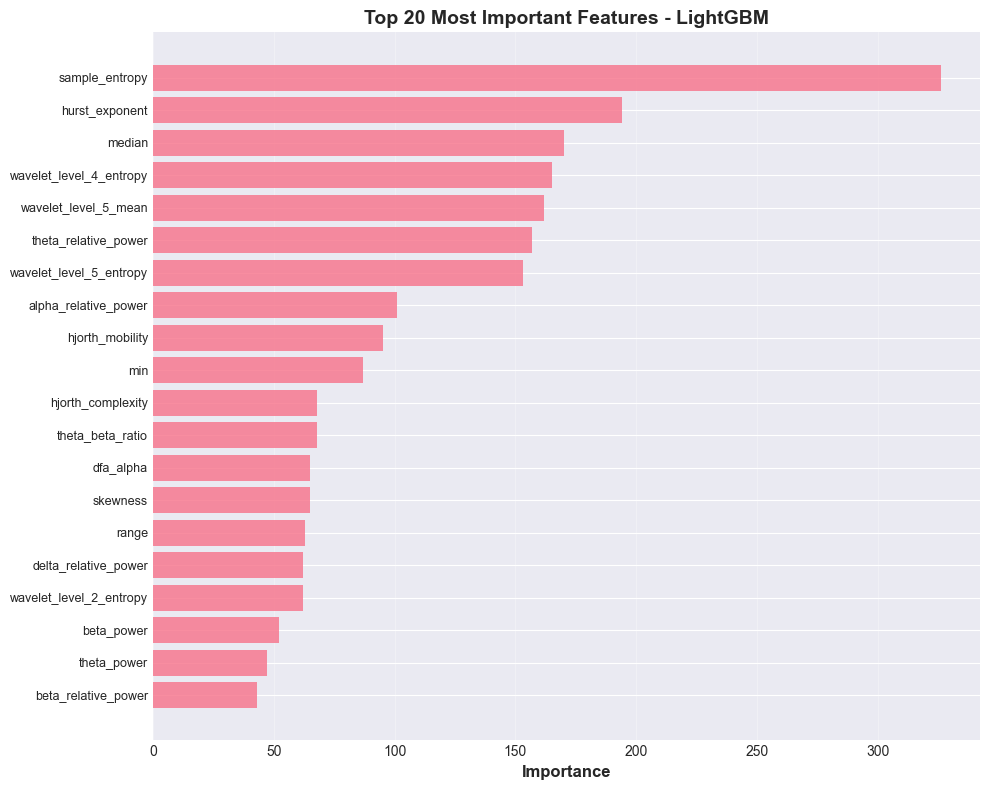

In [21]:
# Visualize top features
print("\nCreating feature importance visualization...")
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 20
top_features = feature_importance_df.head(top_n)

ax.barh(range(top_n), top_features['Importance'].values, alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'].values, fontsize=9)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Most Important Features - {best_model_name}', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_importance_final.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

In [22]:
visualizer = Visualizer()


 Confusion Matrix...


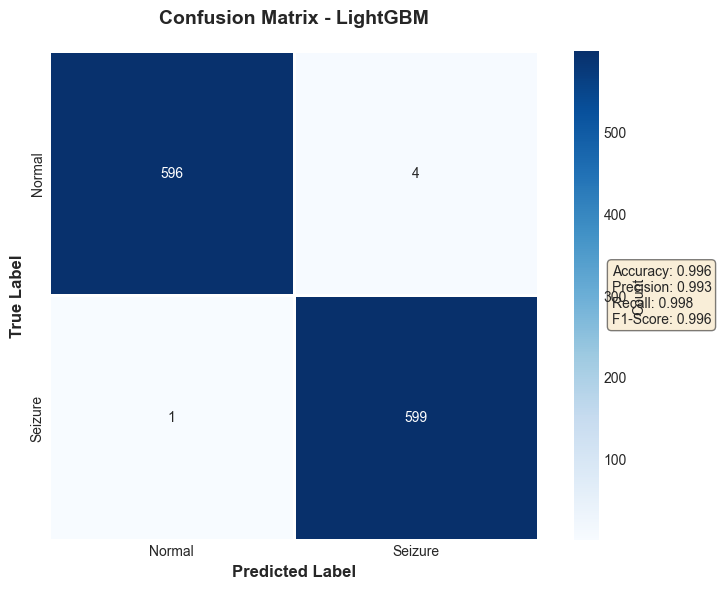

In [23]:
# 1. Confusion Matrix
print("\n Confusion Matrix...")
fig = visualizer.plot_confusion_matrix(
    y_test, y_pred,
    class_names=['Normal', 'Seizure'],
    title=f'Confusion Matrix - {best_model_name}'
)
plt.savefig(FIGURES_DIR / 'confusion_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()


 ROC Curve...


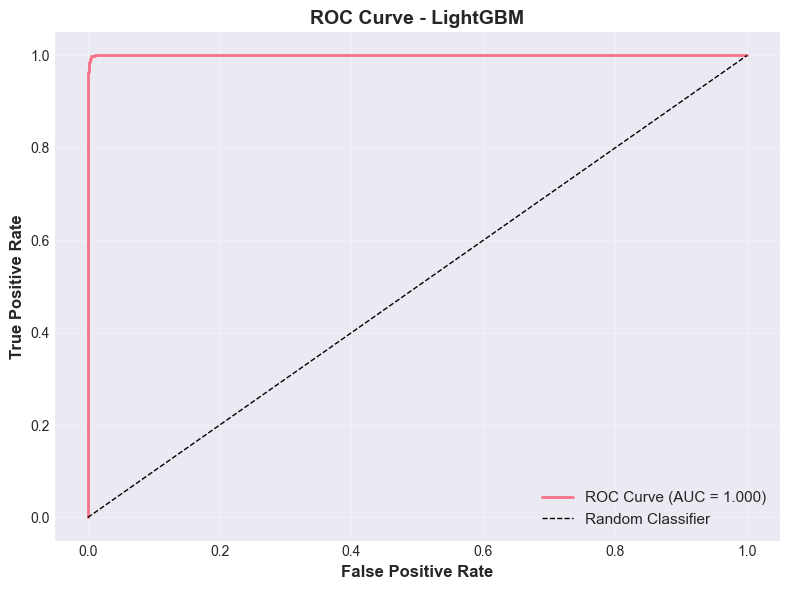

In [24]:
# 2. ROC Curve
print("\n ROC Curve...")
fig = visualizer.plot_roc_curve(
    y_test, y_proba,
    title=f'ROC Curve - {best_model_name}'
)
plt.savefig(FIGURES_DIR / 'roc_curve_final.png', dpi=300, bbox_inches='tight')
plt.show()


 Precision-Recall Curve...


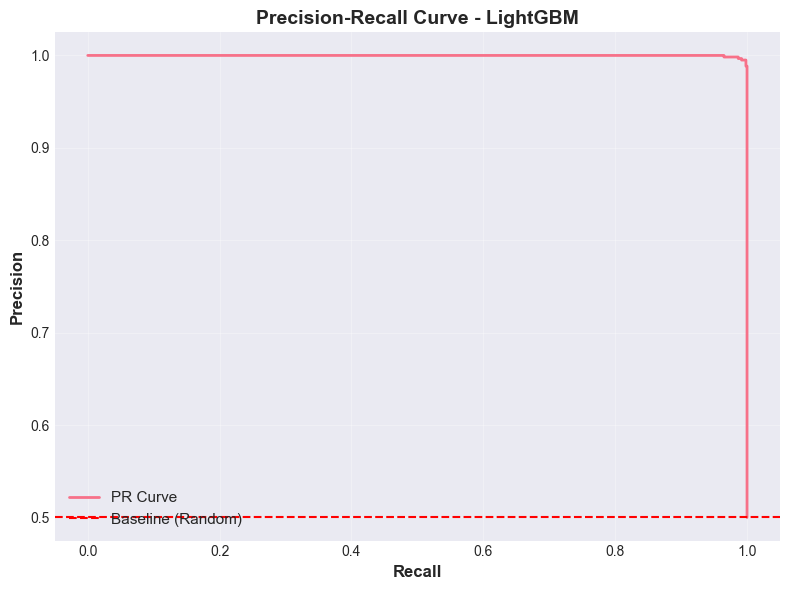

In [25]:
#  3. Precision-Recall Curve
print("\n Precision-Recall Curve...")
fig = visualizer.plot_precision_recall_curve(
    y_test, y_proba,
    title=f'Precision-Recall Curve - {best_model_name}'
)
plt.savefig(FIGURES_DIR / 'precision_recall_curve_final.png', dpi=300, bbox_inches='tight')
plt.show()


 Prediction Confidence Distribution...


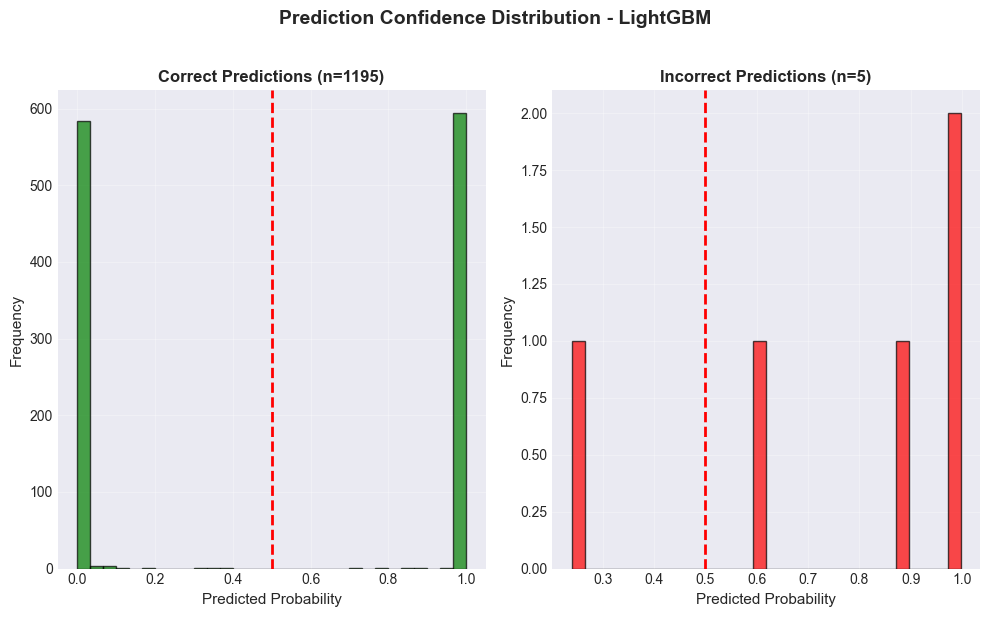

In [26]:
# 4. Confidence Distribution
print("\n Prediction Confidence Distribution...")
fig = visualizer.plot_confidence_distribution(
    y_test, y_proba,
    title=f'Prediction Confidence Distribution - {best_model_name}'
)
plt.savefig(FIGURES_DIR / 'confidence_distribution_final.png', dpi=300, bbox_inches='tight')
plt.show()


 Model Comparison...


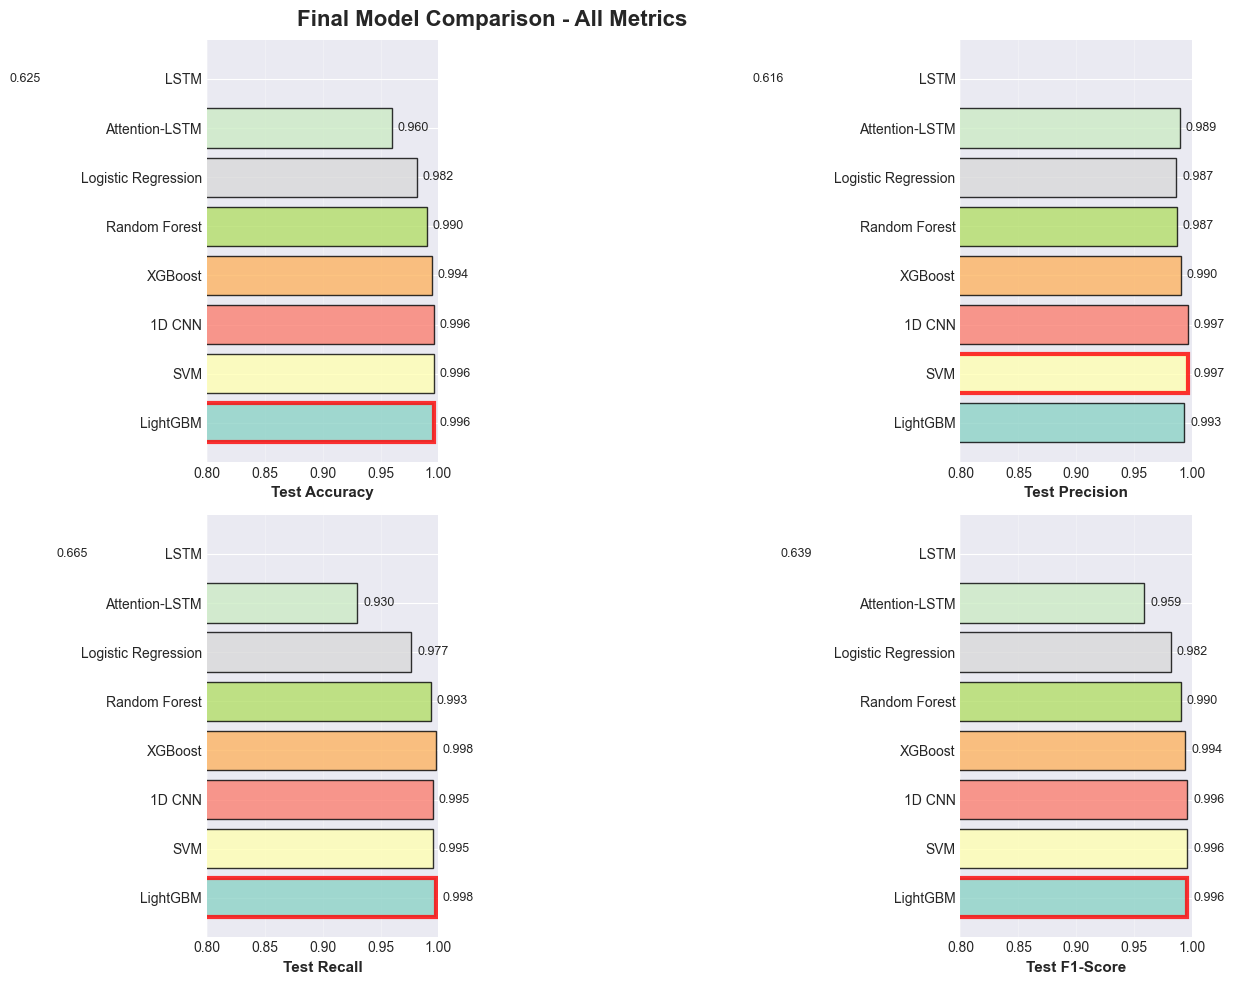

In [27]:
# 5. Model Comparison Summary For All Models
print("\n Model Comparison...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

metrics_to_plot = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']
colors = plt.cm.Set3(np.linspace(0, 1, len(comparison_df)))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    bars = ax.barh(comparison_df['Model'], comparison_df[metric], color=colors, alpha=0.8, edgecolor='black')
    ax.set_xlabel(metric, fontsize=11, fontweight='bold')
    ax.set_xlim([0.8, 1.0])
    ax.grid(True, alpha=0.3, axis='x')
    
    # Highlight best model
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.005, bar.get_y() + bar.get_height()/2,
               f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.suptitle('Final Model Comparison - All Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison_final.png', dpi=300, bbox_inches='tight')
plt.show()